# Machine Learning for Climate Science Tutorial with Python

In this three-part tutorial series, we introduce some of the basic tools that are used in machine learning that may be useful for the tasks presented in _Challenge 3: Machine learning with climate and weather data_. 

__Note:__ this is a beginner's tutorial and aimed at students/researchers who are new to machine learning or are just getting started.

## Introduction
Broadly speaking, machine learning is a sub-field of artificial intelligence and statistics that deals with the automatic extraction of patterns (i.e. learning) from large amounts of data. We may categorize the types of learning as either __supervised__ or __unsupervised__ depending on whether the data we are given is labelled or not (there are also other types of learning such as _reinforcement learning_ that deals with learning from past mistakes, and *semi-supervised learning*, where only a subset of the data is labelled).

![Different types of machine learning](../images/ml-types.png)

In this tutorial, we'll only be concerned with supervised learning tasks, so our data will be *labelled*, which means that it consists of a pair $(X_n, y_n)_{n=1}^N$ of __inputs__ $X_n$ and __labels__ $y_n$.

__Example:__ The inputs $X_n$ are images of chihuahuas and muffins, and the labels $y_n$ are the tags 'chihuahua' or 'muffin' (yes you read that right).

![chihuahuas vs muffins](../images/dogmuffin.png)

The primary task of supervised learning is to find a mapping $f : X \mapsto y$ that best represents the relationship between the inputs and labels, which, in ML lingo, is called **fitting the data**. Depending on whether the labels $y_n$ take values in a discrete or continuous set, the set of techniques used to fit the data are slightly different. The corresponding tasks also have different names: the former is called __classification__ and the latter is called **regression**.

In this tutorial, we will cover both classification and regression tasks in detail using synthetic data, before moving on to real datasets. The outline of the tutorial is as follows:
1. Classification with the Lorenz 63 system
2. Regression with the Lorenz 96 system
3. Handling real world datasets with `pandas`


## Part 1: Classification with the Lorenz 63 system

In the first part of this tutorial, we are going to introduce the basics of *statistical classification* using the famous Lorenz 63 model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
currentdir = os.path.dirname(os.path.realpath('__file__'))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)
from datasets.lorenz import Lorenz63

The Lorenz 63 model (often shortened as L63) is given by the following three-dimensional set of nonlinear ODEs, introduced by the meteorologist Edward Lorenz in 1963 as a toy model for atmospheric convection:

\begin{align*}
\frac{dx}{dt} &= \sigma (y - x), \\
\frac{dy}{dt} &= x(\rho - z) - y, \\
\frac{dz}{dt} &= xy - \beta z.
\end{align*}

This model is famous for jump-starting the field of _chaos theory_ that has since become important in the physical sciences and especially in meteorology, where it was instrumental in showing the impossibility of forecasting the weather far into the future.

This model has three parameters $(\sigma, \rho, \beta)$, which are usually set at $\sigma = 10, \rho = 28$ and $\beta = 8/3$, at which the system exhibits chaotic behaviour.

Let's integrate and visualise the L63 system with these parameters and see what we get...

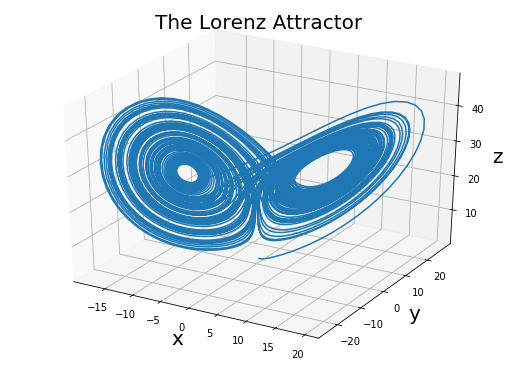

In [2]:
# Generate and plot the Lorenz attractor
tmax = 100
num_samples = 10000
dt = tmax/num_samples # 0.01
X0 = np.array([0, 1, 1.05]) # Initial condition

L63 = Lorenz63(tmax, X0, num_samples)
L63.plot()

The famous butterfly! This butterfly is called the *Lorenz attractor*.

Now let's say that for any point $X_0 = (x_0,y_0,z_0)$ on the Lorenz attractor at time $t=0$, we want to predict where it will be after time $t=1$. Further, let's assume that we have no knowledge of the L63 equations and only have noisy measurements of its $(x,y,z)$-coordinates. 
Is this possible?

Since the L63 system is chaotic, predicting the exact position is going to be impossible so we will reformulate this problem to make it a bit more tractable:

#### Challenge: Given any point $X_0$ on the Lorenz attractor, determine which wing of the butterfly (left or right) it will end up in after time $t=1$.

Here, we define the right/left butterfly wing of the Lorenz attractor according to whether the $x$-component of $X$ is positive or negative respectively.

\begin{align*}
x \leq 0 & \quad \Rightarrow \quad X \in \text{left butterfly wing (class 0)} \\
x > 0 & \quad \Rightarrow \quad X \in \text{right butterfly wing (class 1)}
\end{align*}

You should realise that this is a _classification task_ since the labels 'left butterfly wing' and 'right butterfly wing' form a discrete set.

To proceed, we first construct the function `end_up_on_which_wing` that takes in a L63 trajectory $(X_{t_n})_{n=1}^N$ and outputs a sequence of labels (0 or 1) depending on whether the future point $X_{t_n + \Delta t}$ belongs to the left or right butterfly wing respectively.

In [3]:
def end_up_on_which_wing(X: np.array, lag: int) -> np.array:
    """ Returns array of 0s and 1s corresponding to whether a point on the attractor lands on the
        left or right wing respectively after n = lag timesteps
        Args:
            X: array of shape (num_samples, 3)
        
        Output: array of shape (num_samples - lag, )
    """
    x, y, z = X.transpose()
    return (x[lag:] > 0).astype(int)

We use this to generate the sequence of *labels* for our task.

In [4]:
tfinal = 1.
tsteps = int(tfinal/dt)

X = L63.trajectory
N = L63.num_samples

# Get sequence of 0/1s depending on whether each point X ends up on the left/right wing after time t=1
lag = tsteps
labels = end_up_on_which_wing(X, lag)

Next, let's color-code the points on the attractor to help us visualise the task: orange if the point ends up on the left butterfly wing after time $t=1$ and blue if it ends up on the right butterfly wing.

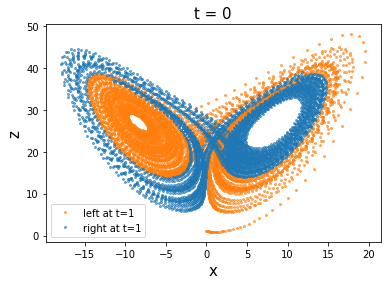

In [5]:
# Get indices corresponding to left/right wing after time t=1
left_indices = np.argwhere(labels == 0)
right_indices = np.argwhere(labels == 1)

# Extract subset of X that lies on the left/right wing after time t=1
eventually_left_X = X[left_indices].squeeze()
eventually_right_X = X[right_indices].squeeze()

# Plot
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()
left_x, left_z = eventually_left_X[:,0], eventually_left_X[:,2]
right_x, right_z = eventually_right_X[:,0], eventually_right_X[:,2]
plt.plot(left_x, left_z, 'o', color='tab:orange', ms=2, alpha=0.6, label=f'left at t={int(tfinal)}')
plt.plot(right_x, right_z, 'o', color='tab:blue', ms=2, alpha=0.6, label=f'right at t={int(tfinal)}')
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('z', fontsize=15)
ax.set_title(f't = 0', fontsize=15)
ax.legend()
plt.show()

We can see from this that our objective is to learn a function $f$ that classifies points on the attractor into the orange or blue regions.

$$f : \text{points on attractor} \rightarrow \{\text{orange region}, \text{blue region}\}.$$

We now construct our labelled dataset $(X, y)$ where the inputs $X$ are noisy observations (here, noise is assumed to be i.i.d. Gaussian) of points on the Lorenz attractor and the labels $y$ are the corresponding 0/1 class, depending on whether it belongs to the orange or blue region above.

In [6]:
# noise level
sigma = 0.1

# i.i.d. Gaussian noise
noise = sigma * np.random.randn(N-lag, 3)

# Dataset for our task
X = X[:N-lag] + noise
y = labels

In the following sections, we will explore three common methods that can be used to fit the data $(X, y)$, namely, logistic regression, decision trees classification and neural network classification.

## 1. Logistic Regression

First, let's look at *logistic regression*, where the idea is to model the *probabilities* of an input $X \in \mathbb{R}^m$ belonging to the classes $1, \ldots, n$,

$$f_i(X) = \mathbb{P}(X \in \text{Class } i), \quad i = 1, \ldots, n,$$

using a so-called *logistic model*, and then classifying based on the predicted probabilities: If $j = \text{argmax}_i f_i(X)$, then we predict that $X$ belongs to class $j$. In general, logistic models take the form:

$$f(X) = \sigma(\text{logit}(X)),$$

where $\sigma$ is the __sigmoid function__ in the binary classification setting (i.e. there are only two classes $0$ or $1$) or the __softmax function__ in the multi-class setting, which squashes real numbers to take values between $0$ and $1$,

![Sigmoid graph](https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F5152157%2F366ce717ad74dfe967a940d9a2161f9b%2Fmain-qimg-6b67bea3311c3429bfb34b6b1737fe0c.jpg?generation=1605711218576073&alt=media)

and the _logit_ is the raw model output before squashing via sigmoid/softmax, usually assumed to be linear in the inputs:

$$\text{logit}(X) = \beta_0 + \beta_1 X_1 + \ldots + \beta_m X_m.$$

Here, $\boldsymbol{\beta} = (\beta_0, \beta_1, \ldots, \beta_m)$ are the parameters of the logistic model, that is to be learned during training.

To simplify our discussion on how to fit our model (i.e. finding the optimal $\boldsymbol{\beta}$), we'll only discuss the binary classification setting, but the idea can be extended easily to the multi-class setting. Note that for binary classification, we only need to model the probability of $X$ belonging to class $1$, as the probability of belonging to class $0$ can be computed by simply subtracting from $1$, i.e.,

$$f(X) = \mathbb{P}(X \in \text{Class } 1), \quad \text{then} \quad 1-f(X) = \mathbb{P}(X \in \text{Class } 0).$$

### Loss function and model fitting

To train the model, we begin by treating the labels $0$ and $1$ as the *probabilities* of the input belonging to class $1$. Our objective then is to get our predictive probabilities $\hat{y} = f(X)$ as close as possible to the target probabilities $y = 0$ or $1$, so for example, if the input data $X$ has label $y=1$, then we want our model to predict a *high probability* $f(X) \approx 1$, and likewise if it has label $y=0$, then we want it to predict a *low probability* $f(X) \approx 0$.

One can show that this essentially boils down to finding a model parameter $\boldsymbol{\beta}^*$ that minimizes the **cross-entropy loss** (see [this article](https://machinelearningmastery.com/cross-entropy-for-machine-learning/) for more details):

$$L(Y, \hat{Y}) = - \left[Y \log \hat{Y} + (1 - Y) \log(1 - \hat{Y})\right], \quad \text{where} \quad \hat{Y} = f(X; {\boldsymbol \beta})$$

which measures the discrepancy between two probability distributions $Y$ and $\hat{Y}$. Evaluating $L$ at the observed data $(X_n, y_n)$ and computing the average,
$$\mathcal{L}(\boldsymbol{\beta}) = \frac1N \sum_{n} L(y_n, f(X_n; {\boldsymbol \beta})),$$
this becomes a function of $\boldsymbol{\beta}$ only, which can then be minimized using gradient-descent to obtain $\boldsymbol \beta^* = \text{argmin}_{\boldsymbol \beta} \, \mathcal{L}(\boldsymbol{\beta})$.

While it's good to know these details, all of this can be done automatically using the `scikit-learn` library in `python`!

In [7]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

A good practice in machine learning is to split the dataset into a __training__ and __testing set__.

![training-testing-set](https://docs.splunk.com/images/thumb/3/3b/TrainTest.png/550px-TrainTest.png)

The training set is used to fit the model (i.e. determine the model parameters) and the testing set is only used at the very end to evaluate the performance of the model that was fit on the training set. By evaluating on the testing set which is not seen during training, we get an unbiased assessment of the model performance. Usually, training sets are chosen to be larger than the test sets such as an 80/20% split.

__Tip:__ It is also a good practice to take a small chunk (approx. 10-20%) out of the training set called the *validation set* which can be used to select the best model and model configurations (i.e. tuning the model hyperparameters) before doing a final, final evaluation on the test set.

In `scikit-learn`, splitting the dataset randomly into training and testing sets can be achieved easily using `train_test_split`.

In [8]:
# Split dataset into training (80%) and testing sets (20%)
train_X, test_X, train_y, test_y = train_test_split(X, labels, test_size=0.2)

Next, we wish to fit the logistic model on the training data, which can be done easily using the `fit` method.

In [9]:
# Set up logistic model
model_lr = LogisticRegression()

# Fit model to training data
model_lr.fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Predicting the outputs of the model in `scikit-learn` is also very easy by using the `predict` method. Below, we plot the predictions of the model on the test dataset against the true labels.

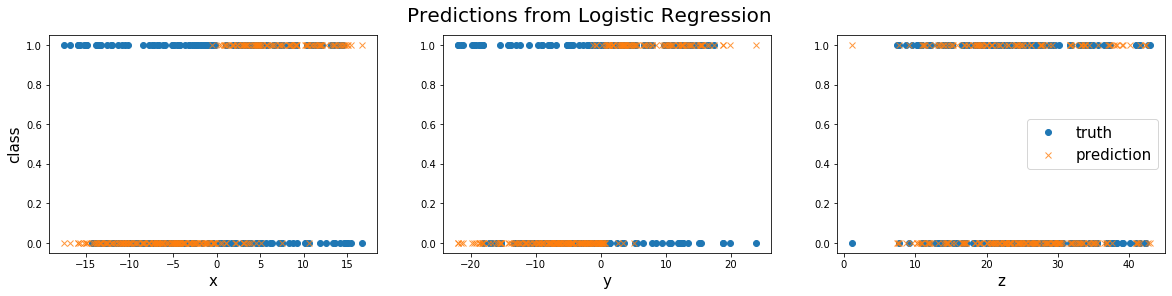

In [10]:
def plot_predictions(f, X, y, title):
    ypred = f(X)
    fig = plt.figure(figsize=(20, 4))
    coord = {0: 'x', 1: 'y', 2: 'z'}
    for i in range(3):
        ax = plt.subplot(1, 3, i+1)
        plt.plot(X[:250,i], y[:250], 'o', label='truth')
        plt.plot(X[:250,i], ypred[:250], 'x', alpha=0.8, label='prediction')
        ax.set_xlabel(coord[i], fontsize=15)
        if i==0:
            ax.set_ylabel('class', fontsize=15)
    ax.legend(fontsize=15)
    plt.suptitle(title, fontsize=20)
    plt.show()

plot_predictions(model_lr.predict, test_X, test_y, 'Predictions from Logistic Regression')

We see that the predictions from the fit model are not perfect and misclassifies many points. To quantify the percentage of points that the model classifies correctly, we can use the `score` method:

In [11]:
# Evaluate model on the test set
accuracy_lr = model_lr.score(test_X, test_y)
print("Accuracy of logistic regression: {:.4f}".format(accuracy_lr))

Accuracy of logistic regression: 0.6626


The result isn't too bad (at least it's better than chance), but there is definitely room for improvement!

### Extending the feature vector with nonlinear features

One way to improve the model performance is by extending or reducing the number of *features* used for prediction. *Feature* is just a fancy name for the components of the input vector used to predict the output labels. For example in our case, the features that were used for prediciton are the $x, y$ and $z$ components of the points in the Lorenz attractor.

However, we could have also considered a simpler model that makes predictions just based on the $x$ and $z$ components, or introduced a new feature $w = xy$ and made predictions based on the four-dimensional feature vector $(x, y, z, w)$.

Manipulating and extending the features can improve the model when the raw inputs don't necessarily capture the information we need to fit the data. For example, if the data distribution has a quadratic trend, then clearly, augmenting the data with quadratic features will do better.
On the other hand, reducing the number of features can be beneficial when there are too many features present, which often leads to *overfitting* (i.e., when a function fits closely to a limited set of data points but does not generalise well).

In the following, we choose to *extend* the number of features using the nonlinear map $\psi: \mathbb{R}^3 \rightarrow \mathbb{R}^6$ (called the *feature map*), given by

$$\psi(x, y, z) = (x, y, z, xy, yz, xz)^T,$$

thus augmenting the three components of L63 with extra quadratic interaction terms $xy$, $yz$ and $xz$. We can do this in `scikit-learn` as follows.

In [12]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
psi = poly.fit_transform

# Extend features in training and testing set
train_X_extended = psi(train_X)
test_X_extended = psi(test_X)

Next, we fit a logistic regression model on this new training set with extended features, i.e. we fit a new model of the form

$$f(x,y,z) = \sigma( \boldsymbol{\beta}^T \psi(x,y,z) ) = \sigma(\beta_0 + \beta_1 x + \beta_2 y + \beta_3 z + \beta_4 xy + \beta_5 yz + \beta_6 xz)$$

In [13]:
# Set up new logistic regression model
model_lr_plus = LogisticRegression()

# Fit model on the extended training set
model_lr_plus.fit(train_X_extended, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

and evaluate this new model on the extended test set as before:

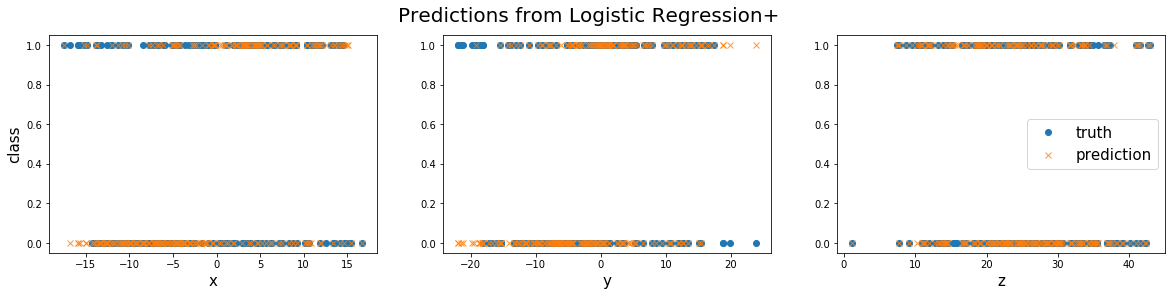

Accuracy of logistic regression with extra quadratic features: 0.7298


In [14]:
# Plot predictions and evaluate accuracy
accuracy_lr_ext = model_lr_plus.score(test_X_extended, test_y)
plot_predictions(model_lr_plus.predict, test_X_extended, test_y, 'Predictions from Logistic Regression+')
print("Accuracy of logistic regression with extra quadratic features: {:.4f}".format(accuracy_lr_ext))

Great! We definitely see an improvement over the vanilla logistic regression! This means that the quadratic interaction terms capture useful information to help us classify the points on the attractor.

## 2. Decision Trees

The next popular method that we are going to investigate is *decision tree classification*. A decision tree is basically a type of look-up table that allow us to make decisions based on various conditions on the features. For example, let's say that there's an alien that arrived on earth for whatever reason that wants to know under what weather conditions they should go to the park without looking suspicious. By observing the humans in the city, they notice that there are three main attributes (features) that contribute to whether a person goes out to the park or not: precipitation, time and temperature. Based on the data they collected, they might form a decision tree like this:

![Decision tree](../images/decisiontree.png)

We'll omit the details on how to actually build a decision tree using the training data, but you can check out [this excellent video](https://www.youtube.com/watch?v=7VeUPuFGJHk) if you want to know more.
In `scikit-learn`, building a decision tree can be done automatically using `DecisionTreeClassifier`.

In [15]:
from sklearn.tree import DecisionTreeClassifier

In pretty much the same way as we have done with logistic regression, building a decision tree from the training data is extremely simple in `scikit-learn`, by using the `fit` method.

In [16]:
# Set up a decision tree model
model_dt = DecisionTreeClassifier()

# fit training data
model_dt.fit(train_X, train_y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Let's visualise the tree that was just constructed and see how it classifies the points on the attractor.

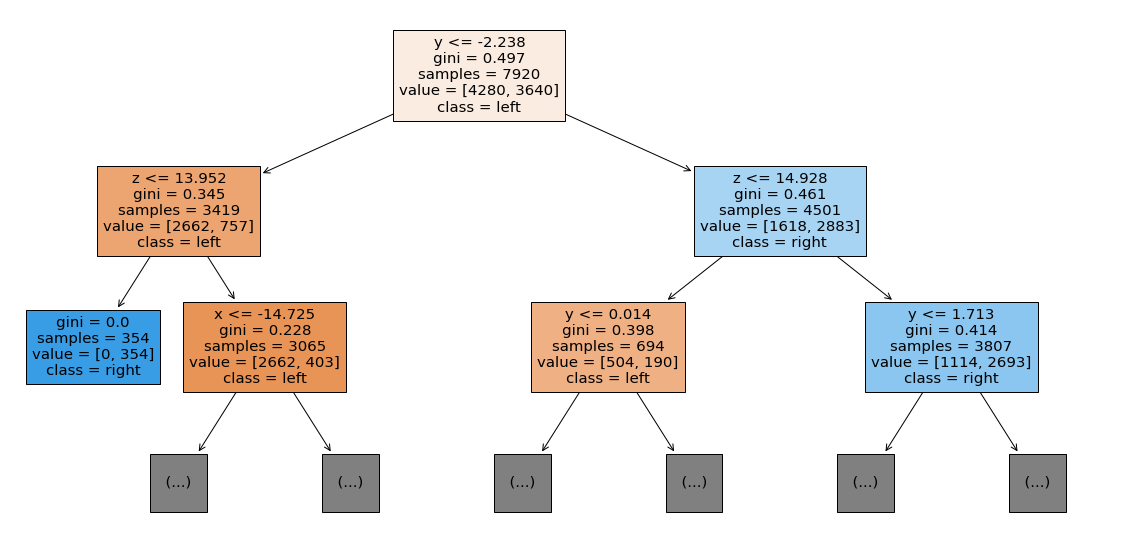

In [17]:
# Plot decision tree (up to depth 2)
fig = plt.figure(figsize = (20, 10))
sklearn.tree.plot_tree(model_dt,
                       max_depth = 2,
                       feature_names = ['x', 'y', 'z'],
                       class_names = ['left', 'right'],
                       filled = True)
plt.show()

Zooming into a single node of the tree, we see that it contains several information:

![decision tree node](../images/tree-node.png)

The first line gives us the condition that is used to classify the inputs further down the tree (here, $z \leq 14.089$). If true, we follow the left arrow and if false, we follow the right arrow. Out of all the inputs in the training set that are fed to this tree, the number of data that end up on this node is displayed in the third line (samples $= 3379$), and the fourth line indicates how many of these training samples belong to the class $0$ or $1$. So if value $= [a, b]$, this means that out of all the training data that end up on this node, there are $a$ samples that belong to class $0$ and $b$ samples that belong to class $1$. Based on this, the last line tells us the most likely class an arbitrary input belongs to if it ended up on that node, which is determined by whether $a > b$ (class $=0$) or $a < b$ (class $=1$).
Finally, the *gini impurity*, indicated in the second line, measures how 'mixed' the training samples are at that node. This is computed as $g = \frac{2ab}{(a+b)^2}$ so it reaches a minimum (zero) if either $a$ or $b$ is zero. If `max_depth` is not specified during training, decision trees will be trained until all the leaves have zero impurity.

Now that we understand how decision tree works, let's go ahead and plot the predictions of the fitted model on the test data and compute the corresponding accuracy:

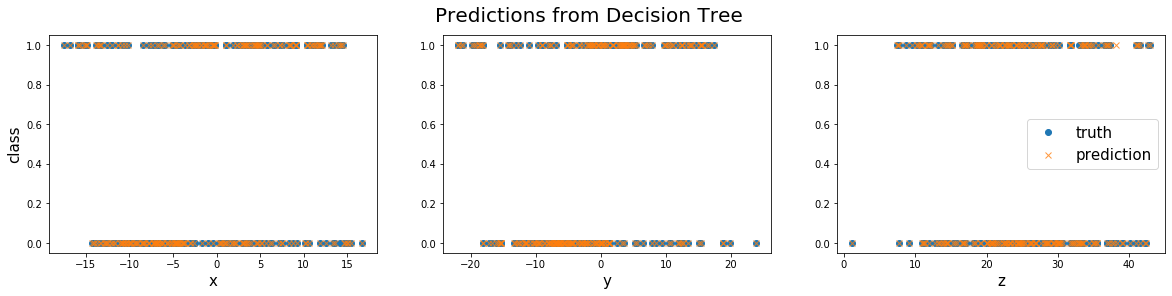

Accuracy of decision tree: 0.9631


In [18]:
# Compute accuracy of fitted tree on test data
accuracy_dt = model_dt.score(test_X, test_y)

# Plot predictions
plot_predictions(model_dt.predict, test_X, test_y, 'Predictions from Decision Tree')

# Print accuracy
print("Accuracy of decision tree: {:.4f}".format(accuracy_dt))

The result is incredible! We see why decision trees are such popular class of models: it is easy to setup, easy to understand (interpretable) and usually does a great job at classifying things. Next, let's see if we can do better by making decisions based on a whole bunch of decision trees instead of just one, giving us a model that is appropriately called *random forests*.

### Random forests

In *random forest classification*, the main idea is to make the decision process a bit more 'democratic' by taking votes from a whole bunch of trees (a *forest* so to say) instead of letting a single tree dictate the decision. This prevents the model from making overconfident decisions, which results in less overfitting and therefore better results.
For example, going back to the chihuahuas-and-muffins dataset from before, let's say that we are given an image of a muffin that really looks like a chihuahua (don't believe me?):

![muffin that looks like a chihuahua](../images/chihuahuamuffin.png)

A single decision tree might misclassify this as a chihuahua, but a random forest might get it right with slightly more votes for 'muffin':

![how random forests vote](../images/chihuahua-muffin-vote.png)

To construct the ensemble of trees in a random forest, we use a technique called *bagging*, which generates $m$ random training datasets by sampling (with replacement) from the original training set $m$ times. These new training datasets are then used to generate the trees in the forest.

Again, this can be done automatically in `scikit-learn` using `RandomForestClassifier`.

In [19]:
from sklearn.ensemble import RandomForestClassifier

Next, we fit the model on the training data as before. Here, we restrict the depth of each tree to a maximum of 15 levels in order to save computation by passing the argument `max_depth=15`.

In [20]:
# Set up random forest model with a maximum depth of 15
model_rf = RandomForestClassifier(max_depth=15)

# Fit random forest on the training data
model_rf.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Below we visualise four trees in the forest that were generated and fitted on the training data. They all look slightly different.

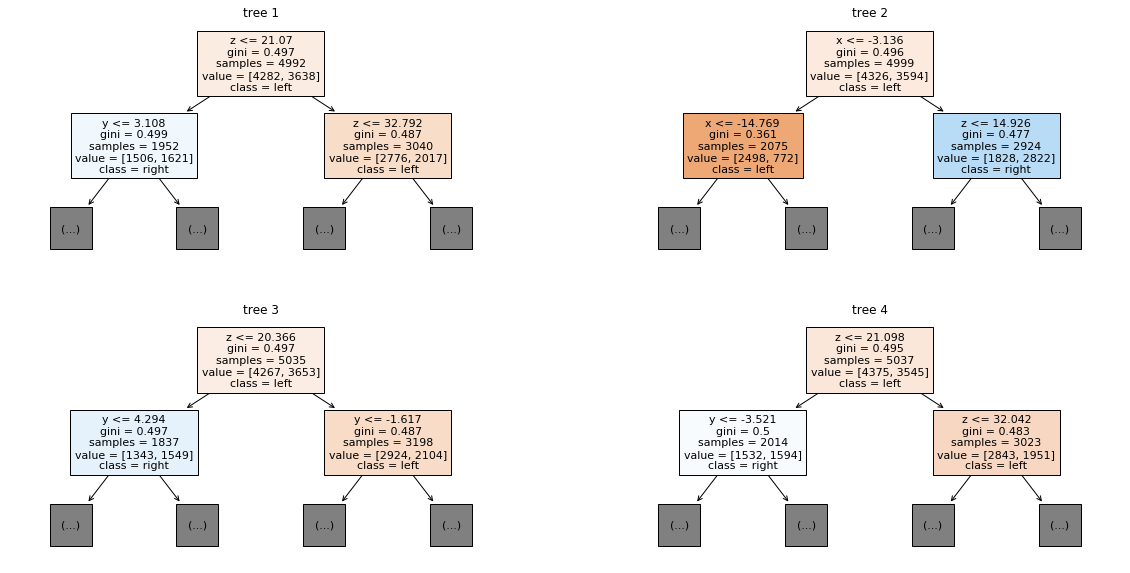

In [21]:
fig = plt.figure(figsize = (20, 10))
for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    sklearn.tree.plot_tree(model_rf.estimators_[i],
                           max_depth = 1,
                           feature_names = ['x', 'y', 'z'],
                           class_names = ['left', 'right'],
                           filled = True)
    ax.set_title(f'tree {i+1}', fontsize=12)
plt.show()

Now let's see how the fitted random forest model performs on the test data.

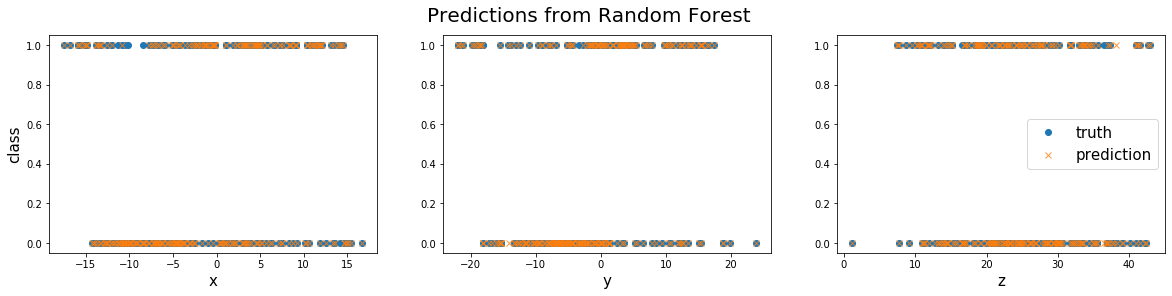

Accuracy of random forest: 0.9657


In [22]:
plot_predictions(model_rf.predict, test_X, test_y, 'Predictions from Random Forest')
accuracy_rf = model_rf.score(test_X, test_y)
print("Accuracy of random forest: {:.4f}".format(accuracy_rf))

Again, we see that this does a great job at classifying the points on the attractor, but we don't see a huge improvement over decision trees (it might even be slightly worse depending on the run). This really depends on the problem at hand and we may or may not see a huge improvement by using random forests. In this case, a single decision tree already does a good job and extending to random forests didn't improve much.

## 3. Neural Networks

Finally, we look at a class of models called *neural networks*, which has become very popular in the last ten or so years due to the increased availability of compute power needed to train them. Neural networks are basically an extremely powerful and flexible class of models that can capture highly complex, nonlinear relationships in data. Here, we'll only look at a certain class of neural networks called *multilayer perceptron (MLP)*, which has the following graphical structure:

![multilayer perceptron](../images/neuralnet.png)

To understand this graph, each node in the figure above, called a *unit*, contains a real number and these are connected by an arrow if the value at the tail depends on the value at the head according to some nonlinear function (we will see its particular form below). In an MLP, these units are stacked into several *layers* that is of one of three types: input, hidden or output. While there is only one each of input and output layers, there can be as many hidden layers as you want (not just two as the figure suggests). We say that the model is *deep* if there is more than one hidden layer, which is where the term *deep learning* comes from.

To make predictions with neural networks, we first get a vector representation of the input $X$ by flattening it if necessary, which is then passed through the input, hidden and output layers as follows (we adopt the notation used in the figure above):

\begin{align*}
(\text{input layer}) \qquad & \quad x_i = flatten(X)_i \\ \\
(\text{hidden layers}) \qquad
&
\begin{cases}
h_i^{(1)} = \phi \left(\sum_j w_{ij}^{(1)} x_j + b_i^{(1)}\right) \\
h_i^{(2)} = \phi \left(\sum_j w_{ij}^{(2)} h_j^{(1)} + b_i^{(2)}\right) \\
\vdots \\
h_i^{(L)} = \phi \left(\sum_j w_{ij}^{(L)} h_j^{(L-1)} + b_i^{(L)}\right)
\end{cases}
\\ \\
(\text{output layer}) \qquad
&\quad o_i = \sum_j w_{ij}^{out} h_j^{(L)} + b_i^{out}.
\end{align*}

The function $\phi : \mathbb{R} \rightarrow \mathbb{R}$ that is applied in the hidden layers is called an *activation function* and they can be any nonlinear, continuous function.
A popular choice for $\phi$ in recent years is the ReLU function, which looks like this:

![relu](https://miro.medium.com/max/357/1*oePAhrm74RNnNEolprmTaQ.png)

This might seem arbitrary but is justified mathematically by the *universal approximation theorem*, which can roughly be stated as follows:

**Theorem:** A multilayer perceptron with ReLU activation function can provide a piecewise linear approximation to *any* continuous function $f$ arbitrarily closely given enough layers or units. This result can be also be extended to arbitrary activation funcitons under certain conditions.

The parameters $(w_{ij}, b_i)$ of the neural network are called the *weights* and *biases* respectively and the objective of neural network modelling is to look for appropriate values of these parameters that best fit the data.

### Classification with neural networks

Classification using neural networks is done in the exact same way as classification using logistic regression, where the logits are now given by the outputs of a neural network, instead of the outputs of a linear model, i.e., first compute the probability

$$
f(X) = \sigma(\text{Neural network}(X)) \in (0, 1),
$$

where $\sigma$ is the sigmoid or softmax function and then classify based on which class gets assigned the highest probability.
The parameters of the model (the weights and biases) can be learnt by optimizing the cross-entropy loss as we saw for logisitic regression using gradient descent or some variant of gradient descent (*Adam* is usually the go-to optimizer for training deep networks). 
MLP classification can therefore be interpreted as a type of logistic regression, where the feature map $\psi$ is *learnt* automatically from data instead of being hand-crafted!

In order to implement an MLP in `python`, we will use the `keras` library, which offers a simple interface for builiding them.

In [23]:
from tensorflow import keras
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers.experimental.preprocessing import Normalization

### 3.1. Data pre-processing

Before sending an input data through the neural network, it is typically a good idea to apply re-scaling in order to increase its performance, since neural network often struggle when a variety of scales are present in the input features (see [this article](https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/) for more details).

Let's look at the range of values that our input training data takes by using a box plot:

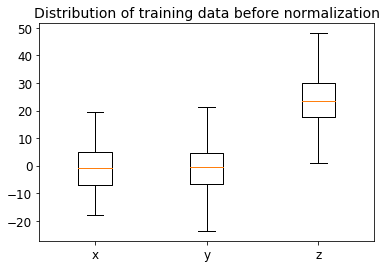

In [24]:
def box_plot(X: np.array, title: str):
    # X must have size (n_samples, 3)
    fig = plt.figure(figsize=(6, 4))
    ax = fig.gca()
    plt.boxplot(X, labels=('x', 'y', 'z'), showfliers=False)
    ax.tick_params(axis='both', labelsize=12)
    plt.title(title, fontsize=14)
    plt.show()

box_plot(train_X, 'Distribution of training data before normalization')

We see that the inputs take a large range of values, with the $z$ component taking much higher values than the $x$ and $y$ components. To fix this, we apply normalization to the training data $X$ by first computing its mean $\mu$ and variance $\sigma^2$, then applying the transformation $\hat{X} = (X - \mu)/\sigma$.

Of course you can apply this transformation by hand, but here we will use the `Normalization` class in `keras`' `preprocessing` module, which does this automatically for us. A nice thing about using `Normalization` to normalize the inputs is that its class instance can be treated as just another layer in the neural network that can be stacked with the other layers, as we will see later.

We use the `adapt` method to compute the mean and variance of the training data, which gets stored in the `mean` and `variance` attributes.

In [25]:
# Instantiate Normalization layer
Normalize = Normalization()

# Adapt to training data (i.e. compute its mean and variance)
Normalize.adapt(train_X)

# Print mean and variance
print(f'mean of training data: {Normalize.mean.numpy()}')
print(f'variance of training data: {Normalize.variance.numpy()}')

mean of training data: [-0.67532164 -0.69018567 23.91227   ]
variance of training data: [63.542343 80.147896 68.959335]


Next, we compute a normalized training dataset $\hat{X}$ by passing the training set $X$ through the `Normalize` object, which applies the transformation $\hat{X} = (X - \mu)/\sigma$ using the values of mean and variance that it has stored earlier.

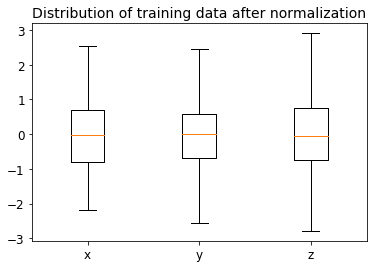

In [26]:
# Normalize training data
train_X_normalized = Normalize(train_X)

# Plot distribution of normalized data
box_plot(train_X_normalized.numpy(), 'Distribution of training data after normalization')

The data distribution looks much better now and we are ready to move on to the next step!

### 3.2. Setting up a neural network with keras

In order to set up a multilayer pereptron in `keras`, we use the `Sequential` class, which build neural networks intuitively by simply stacking up the neural network layers one-by-one:

In [27]:
model_nn = Sequential([
    
    # input layer
    Input(shape=(3,)),
    
    # normalization
    Normalize,
    
    # hidden layers
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    
    # output layer
    Dense(1, activation='sigmoid')

])

Let's break this down step-by-step. First of all, we can see intuitively that we are just stacking up the neural network layers in order, as "input layer -> normalizing layer -> hidden layers -> output layer".

The input layer in `keras` is modelled using the `Input` object and here, we have chosen to specify the shape of our input explicitly by passing the argument `shape=(3,)` to prevent bugs (if `shape` is not specified, this allows us to plug in input tensors of any shapes without raising errors).
We can then either 1.) use the normalized training/test data as inputs, or 2.) use the unprocessed training/test data as inputs but apply normalization as part of the network architecture. Here, we choose to do the latter, which can done by stacking the `Normalize` layer that we just created right after the input layer.

The hidden and output layers will be modelled in `keras` using the `Dense` object, which takes in the number of units and activation function as arguments, and implements the operation $y = \phi(Wx + b)$, where $\phi$ is the activation function that is specified (if activation is unspecified, we just get an affine transformation). 
Thus, we see that our network consists of $5$ hidden layers with ReLU activation, each with $100$ units, and an output layer of a single unit with sigmoid activation.

Next, we specify the loss function and optimizer that we use to train our model, two essential ingredients aside from the network itself:

In [28]:
# Set loss function to be cross-entropy loss for binary classification
loss_fn = keras.losses.BinaryCrossentropy()

# Use the Adam optimizer
opt = keras.optimizers.Adam()

and put all of these components together, using the `compile` method:

In [29]:
# Compile the model
model_nn.compile(loss=loss_fn,
                 optimizer=opt,
                 metrics=['accuracy'])

Note that we have specified `accuracy` as the metric with which we assess the model performance. Finally, we display the details of the network that we just put together using the `summary` method:

In [30]:
model_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 3)                 7         
_________________________________________________________________
dense (Dense)                (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 1

### 3.3. Training and testing

Now we are ready to fit our neural network on the training data. As we have done with logistic regression and decision trees, fitting a neural network in `keras` is super simple if we use the `fit` method (warning: you will get an error if you forget to compile the model with a loss function and an optimizer in the previous step). We also have to specify the number of *training epochs*, which is how many times the optimization algorithm cycles over the entire training dataset to minimize the loss. Here we choose `epochs=10`.

In [31]:
model_nn.fit(train_X, train_y, epochs=10)

Epoch 1/10
248/248 [==============================] - 2s 7ms/step - loss: 0.4456 - accuracy: 0.8040
Epoch 2/10
248/248 [==============================] - 1s 3ms/step - loss: 0.2311 - accuracy: 0.8984
Epoch 3/10
248/248 [==============================] - 1s 4ms/step - loss: 0.1929 - accuracy: 0.9146
Epoch 4/10
248/248 [==============================] - 1s 5ms/step - loss: 0.1502 - accuracy: 0.9335
Epoch 5/10
248/248 [==============================] - 1s 2ms/step - loss: 0.1468 - accuracy: 0.9337
Epoch 6/10
248/248 [==============================] - 1s 5ms/step - loss: 0.1380 - accuracy: 0.9360
Epoch 7/10
248/248 [==============================] - 1s 4ms/step - loss: 0.1226 - accuracy: 0.9442
Epoch 8/10
248/248 [==============================] - 1s 4ms/step - loss: 0.1325 - accuracy: 0.9394
Epoch 9/10
248/248 [==============================] - 1s 3ms/step - loss: 0.1211 - accuracy: 0.9433
Epoch 10/10
248/248 [==============================] - 1s 4ms/step - loss: 0.1140 - accuracy: 0.9475

Now that we've fitted our model on the training set, we want to plot the predictions on the test set!

__Note:__ Our keras neural network only outputs the probability of belonging to class 1, so we first have to do a bit of fidgeting by wrapping our model with the class `to_binary`, which gives us a binary output of 0 or 1 depending on whether the output probability is less than 0.5 or not.

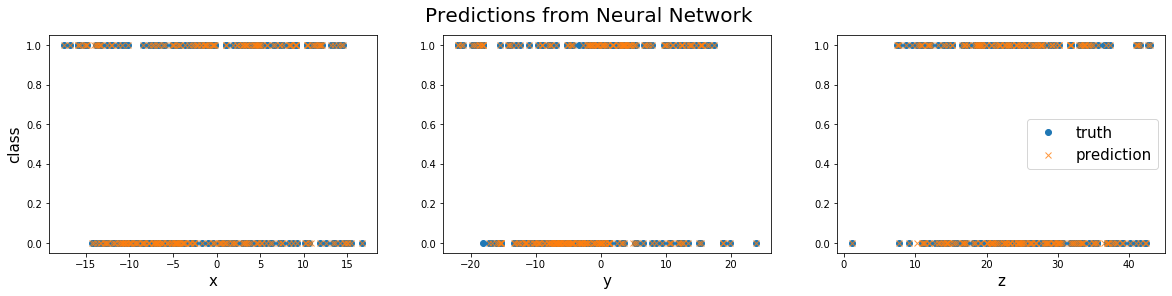

In [32]:
class to_binary():
    def __init__(self, model, cutoff=0.5):
        self.model = model
        self.cutoff = cutoff
    def predict(self, X):
        ypred = self.model(X)
        ypred_binary = np.array([0 if p < self.cutoff else 1 for p in ypred])
        return ypred_binary

model_nn_binary = to_binary(model_nn)
plot_predictions(model_nn_binary.predict, test_X, test_y, 'Predictions from Neural Network')

Looks pretty good! Now let's get a quantitative evaluation of the performance on the test set using the `evaluate` method.

In [33]:
loss_nn, accuracy_nn = model_nn.evaluate(test_X, test_y)

62/62 [==============================] - 0s 1ms/step - loss: 0.1112 - accuracy: 0.9520


We see that the neural network does significantly better than logistic regression (both the vanilla version and the version with extended features), however it does not out-perform the decision tree/random forest classification. Hence, the winner of this task is decision tree/random forests!

__Tip:__ Experiment with different numbers of hidden layers, units, number of epochs, etc in the neural network and see how it affects the test accuracy. Also observe what happens when you remove the normalization layer from the network. You should see that the performance becomes slightly worse!